In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import traceback
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from pulearn import ElkanotoPuClassifier, BaggingPuClassifier
from sklearn.metrics import roc_curve, auc
 


In [75]:
def select_features_by_iv(df_transformed, iv_scores, target_col, iv_min_threshold=0.02, iv_max_treshold = 0.5, print_ = True):
    cols_to_keep = []

    if print_:
        print("--- IV-Based Feature Selection ---")
        
    for original_col, iv_value in iv_scores.items():
        woe_col_name = f'{original_col}_WoE'
        
        if iv_value < iv_min_threshold:
            if print_:
                print(f"DROPPING: {woe_col_name} (IV={iv_value:.4f}) - Too weak.")
        elif iv_value > iv_max_treshold:
            if print_:
                print(f"DROPPING: {woe_col_name} (IV={iv_value:.4f}) - Too strong.")
        else:
            if print_:
                print(f"KEEPING:  {woe_col_name} (IV={iv_value:.4f})")
            cols_to_keep.append(woe_col_name)
    
    final_cols = cols_to_keep + [target_col]
    return df_transformed[final_cols]


 

In [76]:
def plot_logistic_regression_coefs(df_trasnfromed, woe_maps, p_values, logreg_coefs):
    
    ### First, thake the significant columns.
    alpha = 0.05
    significant_filter = p_values <= alpha
    significant_coefs = logreg_coefs[significant_filter]
    if 'const' in significant_coefs.index:
        significant_coefs = significant_coefs.drop('const')
        
    # reverse_woe_maps = create_reverse_woe_maps(woe_maps)
    category_contributions = {}

    for feature_woe_name, coef_value in significant_coefs.items():
        original_col_name = feature_woe_name.replace('_WoE', '')
        woe_map = woe_maps.get(original_col_name)
        if woe_map:
            contributions_list = []
            for category, woe_score in woe_map.items():
                contribution = woe_score * coef_value
                contributions_list.append({
                    'category': category,
                    'WoE_Score': woe_score,
                    'Coefficient': coef_value,
                    'Contribution_LogOdds': contribution
                })
            contributions_list.sort(key=lambda x: abs(x['Contribution_LogOdds']), reverse=True)
            category_contributions[original_col_name] = contributions_list
            
    all_contributions_list = []

    # Iterate through the dictionary and flatten the structure
    for feature_name, contributions_list in category_contributions.items():
        # contributions_list is the list of dictionaries for a single feature
        for item in contributions_list:
            # Add the feature name to the dictionary for context
            item['Feature'] = feature_name
            all_contributions_list.append(item)

    # 3. Create the DataFrame from the single, flattened list of dictionaries
    df_contributions = pd.DataFrame(all_contributions_list)
    
    df_contributions['Abs_Contribution'] = df_contributions['Contribution_LogOdds'].abs()
    df_contributions = df_contributions.sort_values(
        by=['Abs_Contribution', 'Contribution_LogOdds'], 
        ascending=[False, False]
    )

    # Select the Top N for plotting (from both ends)
    N = 10
    df_head = df_contributions.head(N)
    df_tail = df_contributions.tail(N)
    df_plot = pd.concat([df_head, df_tail]).drop_duplicates()

    # Create a clean label for the Y-axis combining Category and Feature
    df_plot['category'] = df_plot['category'].astype(str)
    df_plot['Feature'] = df_plot['Feature'].astype(str)

    # Now perform the concatenation, which should succeed
    df_plot['Combined_Label'] = df_plot['category'] + ' (' + df_plot['Feature'] + ')'

    df_plot = df_plot.sort_values(
        by=['Contribution_LogOdds'], 
        ascending=False # Sorts highest positive contribution to lowest negative contribution
    ).reset_index(drop=True)

    
    # Define a column to determine the color (Red for Negative, Green for Positive)
    df_plot['Color_Group'] = df_plot['Contribution_LogOdds'].apply(
        lambda x: 'Positive' if x >= 0 else 'Negative'
    )

    # --- 3. Create the Bar Chart ---
    plt.figure(figsize=(12, 7)) # Increase size for better label spacing

    sns.barplot(
        x='Combined_Label', 
        y='Contribution_LogOdds', 
        data=df_plot, 
        # Use the new color column for hue and define the custom palette
        hue='Color_Group', 
        palette={'Positive': 'green', 'Negative': 'red'}, 
        dodge=False, # Essential: prevents bars from splitting when using hue
        legend=False 
    )

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Prediktori', fontsize=14)
    plt.ylabel('Log-Odds (Logaritms no izredzēm)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8) 

    plt.tight_layout()  
    plt.show()
        

In [77]:
def format_data_for_logistic_regression(df, categorical_cols, target_col, Smoothing_const=0.5, iv_max_treshold = 0.5, print_ = True):
    """
    Applies WoE encoding to a list of categorical columns and calculates Information Value (IV).
    """
    df_transformed = df.copy()
    woe_maps = {}
    iv_scores = {}
    
    # Calculate overall totals (with smoothing) for the entire dataset
    total_counts = df_transformed[target_col].value_counts()
    total_non_events = total_counts.get(0, 0) + Smoothing_const
    total_events = total_counts.get(1, 0) + Smoothing_const
    
    for col in categorical_cols:
   
        
        # Aggregate counts per category
        woe_df = (
            df_transformed.groupby(col, observed=True)[target_col]
            .agg([
                ('C_1', lambda x: x.sum() + Smoothing_const),
                ('C_0', lambda x: (x.count() - x.sum()) + Smoothing_const)
            ])
            .reset_index()
        )
        
        #  Calculate Distributions, WoE, and IV
        woe_df['D_0'] = woe_df['C_0'] / total_non_events
        woe_df['D_1'] = woe_df['C_1'] / total_events
        woe_df['WoE'] = np.log(woe_df['D_0'] / woe_df['D_1'])
        woe_df['IV'] = (woe_df['D_0'] - woe_df['D_1']) * woe_df['WoE']
        
        #  Store map and total IV
        woe_map = woe_df.set_index(col)['WoE'].to_dict()
        total_iv = woe_df['IV'].sum()
        
        woe_maps[col] = woe_map
        iv_scores[col] = total_iv
        
        #  Apply the WoE map and force float type
        new_col_name = f'{col}_WoE'
        df_transformed[new_col_name] = df_transformed[col].map(woe_map).astype(float) 
        df_transformed[new_col_name] = df_transformed[new_col_name].fillna(0)
        df_transformed = df_transformed.drop(columns=[col])
        
    return select_features_by_iv(df_transformed, iv_scores, target_col, iv_max_treshold=iv_max_treshold, print_=print_), woe_maps, iv_scores

In [78]:
from sklearn.utils import resample

def find_significant_features(X_train, Y_train, categorical_cols,
                              target_col, Smoothing_const, iv_max_treshold = 0.5,
                              Niter = 50, alpha = 0.05):
    
    p_value_sums = pd.Series(dtype=float)
    for i in range(Niter):
        
        # Subsample the Training Data (Bootstrap)
        # X_sub and Y_sub are new DataFrames for this iteration
        X_sub, Y_sub = resample(X_train, Y_train,stratify=Y_train,  random_state=i, replace=True) 

        # Combine for WoE calculation
        df_sub_for_woe = pd.concat([X_sub, Y_sub], axis=1)
        X_sub_transformed, _, _ = format_data_for_logistic_regression(
            df_sub_for_woe, 
            categorical_cols, 
            target_col, 
            Smoothing_const=Smoothing_const,
            iv_max_treshold=iv_max_treshold,
            print_ = False
        )
        
        # Separate the features and target for statsmodels
        X_sub_final = X_sub_transformed.drop(columns=[target_col])
        Y_sub_final = X_sub_transformed[target_col].astype(int)
        classes = np.unique(Y_sub_final)
        weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=Y_sub_final)
        class_weights_sub = {cls: weight for cls, weight in zip(classes, weights_array)}
        sample_weights_sub = Y_sub_final.apply(lambda x: class_weights_sub[x])

        X_sub_with_const = sm.add_constant(X_sub_final, prepend=True)
        logit_model = sm.GLM(Y_sub_final, X_sub_with_const, family=sm.families.Binomial(), var_weights=sample_weights_sub)
        results = logit_model.fit()
        
        p_values_i = results.pvalues
        for feature in p_values_i.index:
            p_value_sums[feature] = p_value_sums.get(feature, 0.0) + p_values_i[feature]
            
    for feature in p_value_sums.index:
        p_value_sums[feature] /= Niter
    p_value_sums = p_value_sums.drop('const', errors='ignore')
    max_average_p_value = p_value_sums.max()
    if max_average_p_value > alpha:
        least_robust_woe_feature = p_value_sums.idxmax()
        original_col_to_drop = least_robust_woe_feature.replace('_WoE', '')
        categorical_cols.remove(original_col_to_drop)
        categorical_cols = find_significant_features(X_train, Y_train, categorical_cols, target_col, Smoothing_const, iv_max_treshold, Niter, alpha)
        
    
    return categorical_cols

In [79]:
def calculate_woe_from_mapping(X_surrogate_WoE, woe_maps, X_train_transformed, iv_scores, target_col, print_= False  ):
        for col, woe_map in woe_maps.items():
            new_col_name = f'{col}_WoE'
            X_surrogate_WoE[new_col_name] = X_surrogate_WoE[col].map(woe_map).astype(float) 
            X_surrogate_WoE[new_col_name] = X_surrogate_WoE[new_col_name].fillna(0)
            X_surrogate_WoE = X_surrogate_WoE.drop(columns=[col])
        
        return X_surrogate_WoE

In [80]:
def model_validation(Y_test_and_probability, list_of_labels ):
    plt.figure(figsize=(8, 8))
    for model, label in zip(Y_test_and_probability, list_of_labels):
        Y_test, y_pred_proba = model
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
         
        plt.plot(
            fpr, tpr, lw=2, 
            label=f'ROC {label} (AUC = {roc_auc:.4f})'
        )
    # Plot the baseline (random guess line)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Patvaļīgs min. (AUC = 0.5)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Viltus pozitīvo rādītājs (1 - specifiskums)', fontsize=14)
    plt.ylabel('Patiesi pozitīvo rādītājs (jutīgums)', fontsize=14)
    plt.legend(loc='lower right')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    
    plt.grid(True)
    plt.show()

    print(f"\nFinal Model AUC-ROC Score on Test Data: {roc_auc:.4f}")

In [81]:
def perform_RN_filtering(df, categorical_cols, target_col, rn_fraction = 8):
        X_full = df[categorical_cols] # Features (only categorical/binned features)
        Y_surrogate = df[target_col].astype(int) 

        # --- A. One-Hot Encoding (OHE) ---
        # This step creates the numerical features needed for distance calculation.
        X_ohe = pd.get_dummies(X_full, columns=categorical_cols, drop_first=True)
    
        P_indices = Y_surrogate[Y_surrogate == 1].index
        U_indices = Y_surrogate[Y_surrogate == 0].index

        # Select the prepared numerical data for P and U
        X_P = X_ohe.loc[P_indices]
        X_U = X_ohe.loc[U_indices]         
        
        P_centroid = X_P.mean(axis=0).values.reshape(1, -1) 

        # 2. Calculate Euclidean distances from U samples to the P centroid
        distances = np.linalg.norm(X_U.values - P_centroid, axis=1)
        rn_threshold = rn_fraction * len(P_indices) / len(df)
        distance_threshold = np.percentile(distances, (1 - rn_threshold) * 100)

        # RNs are those U samples whose distance exceeds the calculated threshold
        RN_indices = X_U.index[distances >= distance_threshold] 
        
        return P_indices, U_indices, RN_indices

In [82]:
def check_the_vif_score(X_final):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_final.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_final.values, i) 
        for i in range(len(X_final.columns))
    ]

    # Sort for easier viewing
    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    print("\nVariance Inflation Factor (VIF) Scores:")
    print(vif_data)

In [83]:
def plot_the_correlation_plot(X_final):
    """ Function to plot the correlation heatmap for the final features used in logistic regression.
    
    It was made as a seperate function for better readability of the main code.

    Args:
        X_final (pandas df): The dataset of final features for log. reg.
    """    
    correlation_matrix = X_final.corr()
    plt.figure(figsize=(6, 5))  
    
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        cbar=False,  
        annot_kws={'size': 12},
        linewidths=0.5,
        linecolor='black'
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
       
    plt.tight_layout()  
    plt.show()

In [84]:
import numpy as np

def pulearn_implementation(X_train, Y_train, X_test):
    # Adding class_weight='balanced' to handle class imbalance does not help here
    # Having no weights seem to perform better in case positive class is the same size as negative class. 
    base = SVC()
    pu_bagging_model = BaggingPuClassifier(
        estimator=base,
        n_estimators=100,  
        max_samples=20,  
        n_jobs=-1            
    )

    pu_bagging_model.fit(X_train, Y_train)
    y_scores = pu_bagging_model.predict_proba(X_test)[:, 1]
 
    return y_scores, pu_bagging_model

In [85]:
def perform_pu_logistic_regression_knn_filter(df, country, rn_fraction=8, Smoothing_const = 0.5, iv_max_treshold = 0.5):
    """
    Performs Positive and Unlabelled (PU) Learning using the distance-based 
    Filtering Technique (replacing the biased classifier with proximity analysis).
    
    RNs are defined as unlabelled samples whose distance to the P-centroid is high.
    The final model is still L1-regularized Logistic Regression.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing features and the surrogate target.
    - rn_threshold (float): This now represents the percentile threshold for distance.
                            e.g., U samples whose distance to P is in the top 30% (rn_threshold=0.3)
                            of all U distances are marked as RN.
    """
    

 
    categorical_cols_unbinned = [
    'Avots',                # Source
    'Sesijas_tips',         # session_type
    'Zimola_grupa',         # Brand_Grouped
    'Ierices_tips',         # Device type
    'Ir_maksas',            # is_payed
    'Atribuetie_ienemumi',  # atributed_revenue
    'Apmeklejumi',          # Visits
    'Produkts'              # Product
]
    categorical_cols = [
    'Avots', 
    'Sesijas_tips', 
    'Zimola_grupa', 
    'Ierices_tips', 
    'Ir_maksas', 
    'Ienemumi_grupeti',     # revenue_binned
    'Apmeklejumi_grupeti',  # visits_binned
    'Produkts_grupets'      # Product_binned
]
    target_col = 'visitor_purchase_type' # Surrogate label (1=P, 0=U)
 
    custom_bins_revenue = [-np.inf, 22.5, 46, np.inf]
    custom_labels_revenue = ['(-inf, 22.5]', '(22.5, 46]', '(46, inf)']

    # Apply the custom binning
    df['Ienemumi_grupeti'] = pd.cut(
        df['Atribuetie_ienemumi'],
        bins=custom_bins_revenue,
        labels=custom_labels_revenue,
        include_lowest=True,
        right=True
    )
    
    custom_bins_visits = [-np.inf, 3, 8, np.inf]
    custom_labels_visits = ['(-inf, 3]', '(3, 8]', '(8, inf)']

    # Apply the custom binning
    df['Apmeklejumi_grupeti'] = pd.cut(
        df['Apmeklejumi'],
        bins=custom_bins_visits,
        labels=custom_labels_visits,
        include_lowest=True,
        right=True
    )
    
    custom_bins_Product = [-np.inf, 1, 3, np.inf]
    custom_labels_Product = ['(-inf, 1]', '(1, 3]', '(3, inf)']

    # Apply the custom binning
    df['Produkts_grupets'] = pd.cut(
        df['Produkts'],
        bins=custom_bins_Product,
        labels=custom_labels_Product,
        include_lowest=True,
        right=True
    )
    
    
    ### Finds the Reliable negatives.
    ### Not really a way to split the data and then perform split
    P_indices, U_indices, RN_indices = perform_RN_filtering(df, categorical_cols_unbinned, target_col, rn_fraction=rn_fraction)
    final_indices = P_indices.append(RN_indices)
    print(f"Total Observed Positives (P): {len(P_indices)}, Total Unlabelled (U): {len(U_indices)}")
    print(f"Identified Reliable Negatives (RN): {len(RN_indices)}")
    if len(P_indices) < 8:
        print("The amount of Positives is too little ")
        return None
    df_filtered = df.loc[final_indices].copy() 
    df_filtered[target_col] = df_filtered[target_col].astype(int)
    
    X = df_filtered.loc[final_indices].drop(columns=[target_col])
    Y = df_filtered[target_col].astype(int)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, 
        Y, 
        test_size=0.2,     
        random_state=123,
        stratify=Y         
    )
    

    categorical_cols = find_significant_features(X_train, Y_train, categorical_cols, target_col,
                                                 Smoothing_const, iv_max_treshold=iv_max_treshold,
                                                 Niter = 50, alpha = 0.05)
    print(f" The important faetures are: {categorical_cols}")
    df_train_for_woe = pd.concat([X_train, Y_train], axis=1)
    
    X_train_transformed, woe_maps, iv_scores = format_data_for_logistic_regression(
        df_train_for_woe, 
        categorical_cols, 
        target_col, 
        Smoothing_const=Smoothing_const,
        iv_max_treshold=iv_max_treshold,
    ) 
    print("\nWoE Transformation Complete.")
    print(f"Total IV Scores per feature: {iv_scores}")
    X_final = X_train_transformed.drop(columns=[target_col])
    Y_final = X_train_transformed[target_col].astype(int)
    print(f'The number of positive indices:  {np.mean(Y_final)}')


    if len(X_final.columns) > 1:
        check_the_vif_score(X_final)
    else:
        print("VIF calculation skipped: Only one feature present after selection.")
    
    try:
        plot_the_correlation_plot(X_final)
        classes = np.unique(Y_final)
        weights_array = compute_class_weight(
            class_weight='balanced', 
            classes=classes, 
            y=Y_final
        )
        class_weights = {cls: weight for cls, weight in zip(classes, weights_array)}
        sample_weights = Y_final.apply(lambda x: class_weights[x])
        X_with_const = sm.add_constant(X_final, prepend=True) 
        logit_model = sm.GLM(
            Y_train,            
            X_with_const,  
            family=sm.families.Binomial(),
            var_weights=sample_weights   
        )
        final_logit_results = logit_model.fit() # Default uses Maximum Likelihood Estimation
        print("\n" + "="*50)
        print("**STATSMODELS FITTED COEFFICIENTS (Standard GLM, Class Weighted)**")
        
        # Print the parameter summary table
        print(final_logit_results.summary())
        # print(final_logit_results.summary().as_latex()) # Uncomment to get LaTeX format
        print("="*50)
 
        X_test_filtered = X_test[categorical_cols].copy()
        df_test_for_woe = pd.concat([X_test_filtered, Y_test], axis=1)
        X_test_ = calculate_woe_from_mapping(df_test_for_woe, woe_maps, X_train_transformed, iv_scores, target_col, print_= False)
        X_test_ = select_features_by_iv(X_test_, iv_scores, target_col, iv_max_treshold = iv_max_treshold, print_ = False)
                
        X_test_with_const = sm.add_constant(X_test_.drop(columns=[target_col]), prepend=True)
        y_pred_proba = final_logit_results.predict(X_test_with_const)
        pu_learn_y_pred_proba, pu_model = pulearn_implementation(X_final, Y_final, X_test_.drop(columns=[target_col]))
        model_validation([[Y_test, y_pred_proba], [Y_test, pu_learn_y_pred_proba]], ['LogReg', 'PuLearn'])
        # 3. Print Results and Prediction Setup
          
        X_surrogate_WoE = df_filtered.copy()
        plot_logistic_regression_coefs(X_train_transformed, woe_maps,final_logit_results.pvalues, final_logit_results.params)
        X_surrogate_with_const = calculate_woe_from_mapping(X_surrogate_WoE, woe_maps, X_train_transformed, iv_scores, target_col, print_= False)
        X_surrogate_without_const = select_features_by_iv(X_surrogate_with_const, iv_scores, target_col, iv_max_treshold = iv_max_treshold, print_ = False)
        
        X_surrogate_with_const = sm.add_constant(X_surrogate_without_const.drop(columns=[target_col]), prepend=True)
        all_probas_surrogate = final_logit_results.predict(X_surrogate_with_const)
        print("\nSurrogate Probabilities (first 5):", all_probas_surrogate[:5])
        print('Now probs')
        X_surrogate_WoE.loc[:, 'pu_score_prn'] = all_probas_surrogate.values
        df_scores = df.copy() 
        df_scores.loc[:, 'pu_score_prn'] = all_probas_surrogate # Assign to the full df index

        mean_proba_P = df_scores.loc[P_indices, 'pu_score_prn'].mean()
        median_proba_P = df_scores.loc[P_indices, 'pu_score_prn'].median()
        mean_proba_U = df_scores.loc[U_indices, 'pu_score_prn'].mean()
        mean_proba_RN = df_scores.loc[RN_indices, 'pu_score_prn'].mean()
        median_proba_RN = df_scores.loc[RN_indices, 'pu_score_prn'].median()
                
        print("\n Probability Sanity Check (P vs. RN Score on Full Data):")
        print("--------------------------------------------------")
        print(f"Mean P vs. RN Score for Observed Positives (P): {mean_proba_P:.4f}")
        print(f"Median P vs. RN Score for Positives (P): {median_proba_P:.4f}")
        print(f"Mean P vs. RN Score for Unlabelled (U): {mean_proba_U:.4f}")
        print(f"Mean P vs. RN Score for Reliable Negatives (RN): {mean_proba_RN:.4f}")
        print(f"Median P vs. RN Score for Reliable Negatives (RN): {median_proba_RN:.4f}")

        # Now for the PU model:
        all_probas_surrogate = pu_model.predict_proba(
            X_surrogate_without_const.drop(columns=[target_col])
        )[:, 1]
        pu_series = pd.Series(all_probas_surrogate, index=X_surrogate_without_const.index)
        df_scores_pulearn = df.copy() 
        df_scores_pulearn.loc[:, 'pu_score_prn'] = pu_series

        mean_proba_P = df_scores_pulearn.loc[P_indices, 'pu_score_prn'].mean()
        median_proba_P = df_scores_pulearn.loc[P_indices, 'pu_score_prn'].median()
        mean_proba_U = df_scores_pulearn.loc[U_indices, 'pu_score_prn'].mean()
        mean_proba_RN = df_scores_pulearn.loc[RN_indices, 'pu_score_prn'].mean()
        median_proba_RN = df_scores_pulearn.loc[RN_indices, 'pu_score_prn'].median()

        print("Sanity Check for pulearn model:")
        print(f"Mean P vs. RN Score for Observed Positives (P): {mean_proba_P:.4f}")
        print(f"Median P vs. RN Score for Positives (P): {median_proba_P:.4f}")
        print(f"Mean P vs. RN Score for Unlabelled (U): {mean_proba_U:.4f}")
        print(f"Mean P vs. RN Score for Reliable Negatives (RN): {mean_proba_RN:.4f}")
        print(f"Median P vs. RN Score for Reliable Negatives (RN): {median_proba_RN:.4f}")

        
        # To better see the what is happening in each of the models,
        # we can plot the Reliable netgatives scores from both models.
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df_scores_pulearn.loc[RN_indices, 'pu_score_prn'], 
            color="skyblue", 
            label=r'$\mathit{pulearn}$ modelis', 
            stat="probability", 
            alpha=0.5
        )
 
        sns.histplot(
            df_scores.loc[RN_indices, 'pu_score_prn'], 
            color="salmon", 
            label='Loģistiskā regresija', 
            stat="probability", 
            alpha=0.5
        )
        plt.axvline(
            x=0.5, 
            color='red', 
            linestyle='--', 
            linewidth=1.5, 
            label='Klasifikācijas slieksnis (0.5)'
        )
 
        plt.xlabel('Prognozētā varbūtība', fontdict={'fontsize': 12})
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('Varbūtība', fontsize=12)
        plt.legend(loc='upper right', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.savefig('rn_scores_comparison.png')
        plt.show()
        
    except Exception as e:
        print(" An error occurred during final model fitting. Printing full traceback:")
        traceback.print_exc()
        return None

In [86]:
rows_with_campain = pd.read_csv(
    'rows_with_campain.csv',
    sep=',',
    engine='python',
    quotechar='"',
    encoding='utf-8',
    on_bad_lines='warn'
)

In [87]:
np.random.seed(123)

In [88]:
rows_with_campain.head()

,Sesijas_tips,Atribuetie_ienemumi,Avots,Ierices_tips,Zimola_grupa,Apmeklejumi,Produkts,visitor_purchase_type,Ir_maksas,Ienemumi_grupeti,Apmeklejumi_grupeti,Produkts_grupets
0,Single-Ad,65.806554,A,A,A,1.0,2,0,False,"(5.1, inf)","(-inf, 3]","(1, 3]"
1,Single-Ad,37.922996,A,A,A,1.0,1,0,False,"(4.15, 5.1]","(-inf, 3]","(-inf, 1]"
2,Multi-Ad,40.961516,A,A,B,2.0,2,0,False,"(4.15, 5.1]","(-inf, 3]","(1, 3]"
3,Single-Ad,66.320464,B,A,B,1.0,2,0,True,"(5.1, inf)","(-inf, 3]","(1, 3]"
4,Single-Ad,119.054357,A,B,B,1.0,5,0,False,"(5.1, inf)","(-inf, 3]","(3, inf)"


Total Observed Positives (P): 20, Total Unlabelled (U): 1526
Identified Reliable Negatives (RN): 207
 The important faetures are: ['Avots', 'Sesijas_tips', 'Zimola_grupa', 'Ir_maksas', 'Ienemumi_grupeti', 'Apmeklejumi_grupeti']
--- IV-Based Feature Selection ---
DROPPING: Avots_WoE (IV=0.7439) - Too strong.
DROPPING: Sesijas_tips_WoE (IV=1.7406) - Too strong.
DROPPING: Zimola_grupa_WoE (IV=0.5513) - Too strong.
KEEPING:  Ir_maksas_WoE (IV=0.2451)
DROPPING: Ienemumi_grupeti_WoE (IV=0.7705) - Too strong.
KEEPING:  Apmeklejumi_grupeti_WoE (IV=0.3352)

WoE Transformation Complete.
Total IV Scores per feature: {'Avots': 0.7438635690728213, 'Sesijas_tips': 1.7406154234807432, 'Zimola_grupa': 0.5512813422799113, 'Ir_maksas': 0.24510278980615066, 'Ienemumi_grupeti': 0.7704883716206742, 'Apmeklejumi_grupeti': 0.335169415521309}
The number of positive indices:  0.08839779005524862

Variance Inflation Factor (VIF) Scores:
                   feature       VIF
0  Apmeklejumi_grupeti_WoE  1.015549
1

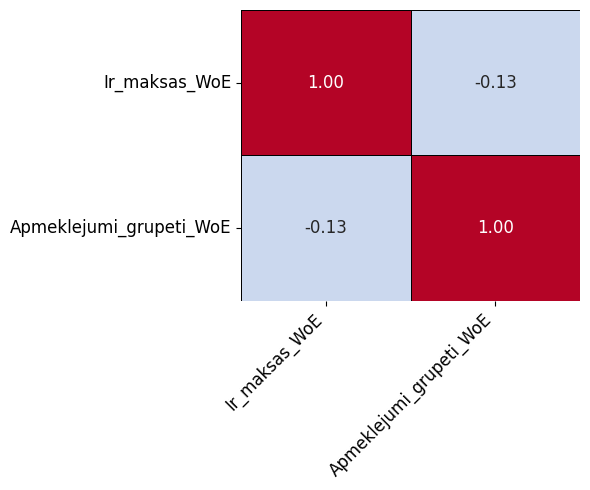


**STATSMODELS FITTED COEFFICIENTS (Standard GLM, Class Weighted)**
                   Generalized Linear Model Regression Results                   
Dep. Variable:     visitor_purchase_type   No. Observations:                  181
Model:                               GLM   Df Residuals:                      178
Model Family:                   Binomial   Df Model:                            2
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -106.42
Date:                   Tue, 20 Jan 2026   Deviance:                       212.84
Time:                           18:03:50   Pearson chi2:                     173.
No. Iterations:                        4   Pseudo R-squ. (CS):             0.1897
Covariance Type:               nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------

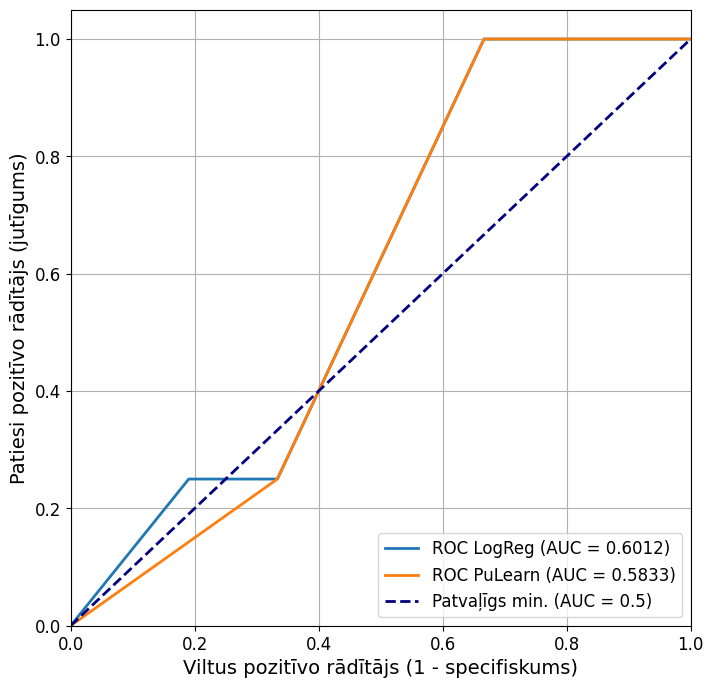


Final Model AUC-ROC Score on Test Data: 0.5833


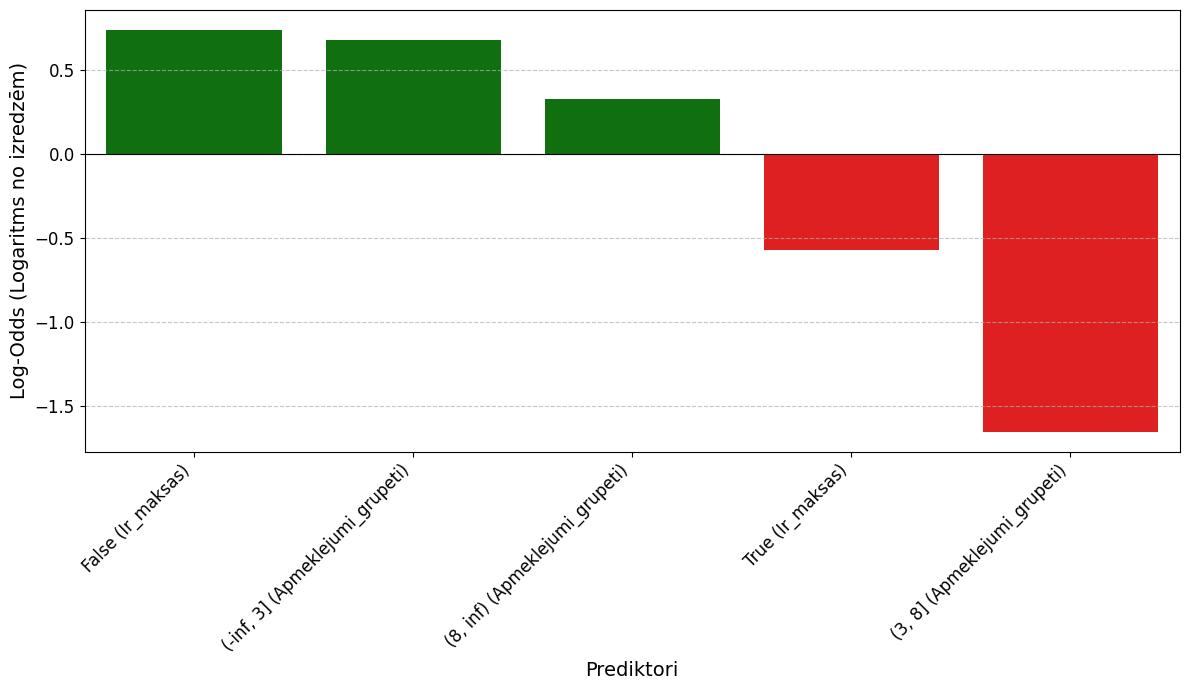


Surrogate Probabilities (first 5): 11    0.750594
21    0.750594
40    0.750594
46    0.750594
54    0.362361
dtype: float64
Now probs

 Probability Sanity Check (P vs. RN Score on Full Data):
--------------------------------------------------
Mean P vs. RN Score for Observed Positives (P): 0.5802
Median P vs. RN Score for Positives (P): 0.5631
Mean P vs. RN Score for Unlabelled (U): 0.4094
Mean P vs. RN Score for Reliable Negatives (RN): 0.4094
Median P vs. RN Score for Reliable Negatives (RN): 0.4478
Sanity Check for pulearn model:
Mean P vs. RN Score for Observed Positives (P): 0.5495
Median P vs. RN Score for Positives (P): 0.5550
Mean P vs. RN Score for Unlabelled (U): 0.2981
Mean P vs. RN Score for Reliable Negatives (RN): 0.2981
Median P vs. RN Score for Reliable Negatives (RN): 0.1200


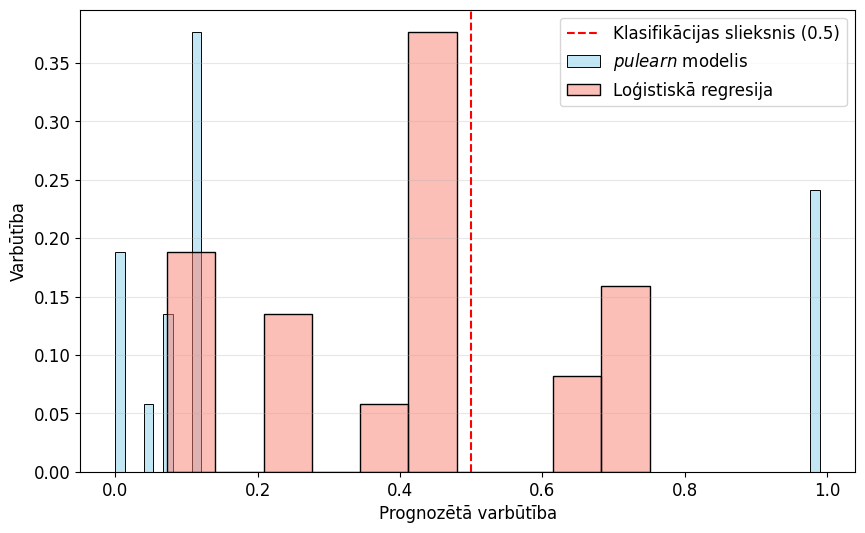

In [89]:

unique_country = 'PL'
perform_pu_logistic_regression_knn_filter(rows_with_campain, unique_country, rn_fraction=10, Smoothing_const=1, iv_max_treshold = 0.5)